Attempt number three at creating a custom Neuron class. Found a paper online with solution to differential equation governing LIF neurons:
https://www.cns.nyu.edu/~eorhan/notes/lif-neuron.pdf
With this result, deduced that Nengo was going off this equation. Now that I understood a little more about their implementation, decided to switch to their LIF implementation, but customized with a randomly defined adjacency matrix. Was successful, but unsure if this is the correct solution to the differential equation as not sure if second term with S and H is actually dependent on v.

Adding new objects to Nengo:
    http://www.bekolay.org/nengodocs-rtd/examples/rectified_linear.html
Step 1:
    Creating a frontend Neurons sublass for new custom neuron type

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import nengo
from nengo.params import Parameter, NumberParam
from nengo.neurons import settled_firingrate

class CustomLIF(nengo.neurons.NeuronType):
    """Spiking version of the leaky integrate-and-fire (LIF) neuron model.

    Parameters
    ----------
    tau_rc : float
        Membrane RC time constant, in seconds. Affects how quickly the membrane
        voltage decays to zero in the absence of input (larger = slower decay).
    tau_ref : float
        Absolute refractory period, in seconds. This is how long the
        membrane voltage is held at zero after a spike.
    min_voltage : float
        Minimum value for the membrane voltage. If ``-np.inf``, the voltage
        is never clipped.
    amplitude : float
        Scaling factor on the neuron output. Corresponds to the relative
        amplitude of the output spikes of the neuron.
    """

    probeable = ("spikes", "voltage", "refractory_time")

    min_voltage = NumberParam("min_voltage", high=0)
    tau_rc = NumberParam("tau_rc", low=0, low_open=True)
    tau_ref = NumberParam("tau_ref", low=0)
    amplitude = NumberParam("amplitude", low=0, low_open=True)
    num = NumberParam("num")

    def __init__(self, tau_rc=0.02, tau_ref=0.002, min_voltage=0, amplitude=2, num=3):
        super().__init__()
        self.tau_rc = tau_rc
        self.tau_ref = tau_ref
        self.amplitude = amplitude
        self.min_voltage = min_voltage
        self.num = num

    def gain_bias(self, max_rates, intercepts):
        """Analytically determine gain, bias."""
        max_rates = np.array(max_rates, dtype=float, copy=False, ndmin=1)
        intercepts = np.array(intercepts, dtype=float, copy=False, ndmin=1)

        inv_tau_ref = 1.0 / self.tau_ref if self.tau_ref > 0 else np.inf
        if np.any(max_rates > inv_tau_ref):
            raise ValidationError(
                "Max rates must be below the inverse "
                "refractory period (%0.3f)" % inv_tau_ref,
                attr="max_rates",
                obj=self,
            )

        x = 1.0 / (1 - np.exp((self.tau_ref - (1.0 / max_rates)) / self.tau_rc))
        gain = (1 - x) / (intercepts - 1.0)
        bias = 1 - gain * intercepts
        return gain, bias


    def max_rates_intercepts(self, gain, bias):
        """Compute the inverse of gain_bias."""
        intercepts = (1 - bias) / gain
        max_rates = 1.0 / (
            self.tau_ref - self.tau_rc * np.log1p(1.0 / (gain * (intercepts - 1) - 1))
        )
        if not np.all(np.isfinite(max_rates)):
            warnings.warn(
                "Non-finite values detected in `max_rates`; this "
                "probably means that `gain` was too small."
            )
        return max_rates, intercepts


    def rates(self, x, gain, bias):
        """Always use LIFRate to determine rates."""
        J = self.current(x, gain, bias)
        out = np.zeros_like(J)
        # Use LIFRate's step_math explicitly to ensure rate approximation
        LIFRate.step_math(self, dt=1, J=J, output=out)
        return out


    def step_math(self, dt, J, spiked, voltage, refractory_time):
        # reduce all refractory times by dt
        refractory_time -= dt

        # compute effective dt for each neuron, based on remaining time.
        # note that refractory times that have completed midway into this
        # timestep will be given a partial timestep, and moreover these will
        # be subtracted to zero at the next timestep (or reset by a spike)
        delta_t = (dt - refractory_time).clip(0, dt)

        # update voltage using discretized lowpass filter
        # since v(t) = v(0) + (S*H*tau)*(1 - exp(-t/tau)) assuming
        # J is constant over the interval [t, t + dt)
        adjacency = self.tau_rc * np.random.rand(3,) * 1000
        voltage -= (adjacency) * np.expm1(-delta_t / self.tau_rc)

        # determine which neurons spiked (set them to 1/dt, else 0)
        spiked_mask = voltage > 1
        spiked[:] = spiked_mask * (self.amplitude / dt)

        # set v(0) = 1 and solve for t to compute the spike time
        t_spike = dt + self.tau_rc * np.log1p(
            -(voltage[spiked_mask] - 1) / (J[spiked_mask] - 1)
        )

        # set spiked voltages to zero, refractory times to tau_ref, and
        # rectify negative voltages to a floor of min_voltage
        voltage[voltage < self.min_voltage] = self.min_voltage
        voltage[spiked_mask] = 0
        refractory_time[spiked_mask] = self.tau_ref + t_spike

Step 2: Create a backend Operator subclass

In [2]:
from nengo.builder.operator import Operator

class SimCustomLIF(Operator):
    """Set a neuron model output for the given input current.

    Implements ``neurons.step_math(dt, J, output, *states)``.

    Parameters
    ----------
    neurons : NeuronType
        The `.NeuronType`, which defines a ``step_math`` function.
    J : Signal
        The input current.
    output : Signal
        The neuron output signal that will be set.
    states : list, optional
        A list of additional neuron state signals set by ``step_math``.
    tag : str, optional
        A label associated with the operator, for debugging purposes.

    Attributes
    ----------
    J : Signal
        The input current.
    neurons : NeuronType
        The `.NeuronType`, which defines a ``step_math`` function.
    output : Signal
        The neuron output signal that will be set.
    states : list
        A list of additional neuron state signals set by ``step_math``.
    tag : str or None
        A label associated with the operator, for debugging purposes.

    Notes
    -----
    1. sets ``[output] + states``
    2. incs ``[]``
    3. reads ``[J]``
    4. updates ``[]``
    """

    def __init__(self, neurons, J, output, states=None, tag=None):
        super().__init__(tag=tag)
        self.neurons = neurons

        self.sets = [output] + ([] if states is None else states)
        self.incs = []
        self.reads = [J]
        self.updates = []

    @property
    def J(self):
        return self.reads[0]

    @property
    def output(self):
        return self.sets[0]

    @property
    def states(self):
        return self.sets[1:]

    def _descstr(self):
        return "%s, %s, %s" % (self.neurons, self.J, self.output)

    def make_step(self, signals, dt, rng):
        J = signals[self.J]
        output = signals[self.output]
        states = [signals[state] for state in self.states]

        def step_simcustomlif():
            self.neurons.step_math(dt, J, output, *states)

        return step_simcustomlif

Step 3: Create a build function

In [3]:
from nengo.builder import Builder
from nengo.builder.operator import Copy
from nengo.builder.signal import Signal
from nengo.rc import rc


@Builder.register(CustomLIF)
def build_customlif(model, neuron_type, neurons):
    """Builds a `.LIF` object into a model.

    In addition to adding a `.SimNeurons` operator, this build function sets up
    signals to track the voltage and refractory times for each neuron.

    Parameters
    ----------
    model : Model
        The model to build into.
    neuron_type : CustomLIF
        Neuron type to build.
    neuron : Neurons
        The neuron population object corresponding to the neuron type.

    Notes
    -----
    Does not modify ``model.params[]`` and can therefore be called
    more than once with the same `.LIF` instance.
    """

    model.sig[neurons]["voltage"] = Signal(
        shape=neurons.size_in, name="%s.voltage" % neurons
    )
    model.sig[neurons]["refractory_time"] = Signal(
        shape=neurons.size_in, name="%s.refractory_time" % neurons
    )
    model.add_op(
        SimCustomLIF(
            neurons=neuron_type,
            J=model.sig[neurons]["in"],
            output=model.sig[neurons]["out"],
            states=[
                model.sig[neurons]["voltage"],
                model.sig[neurons]["refractory_time"],
            ],
        )
    )



In [ ]:
Create an ensemble with 3 neurons of our new custom type.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

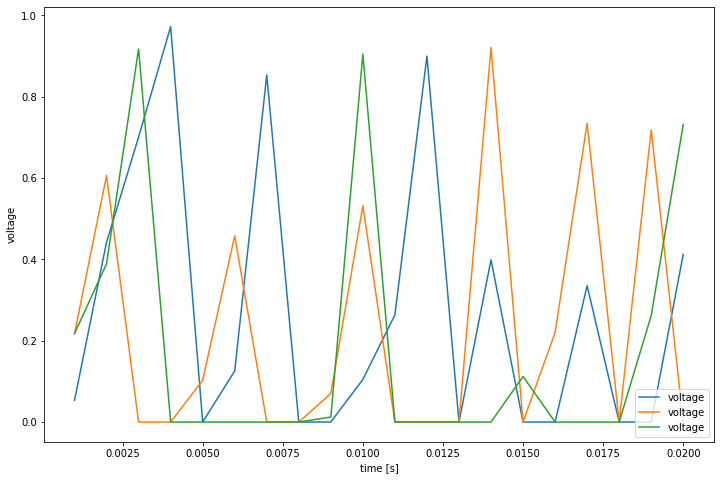

In [4]:
model = nengo.Network(label='2D Representation', seed=10)
process = nengo.processes.WhiteNoise(
    dist=nengo.dists.Gaussian(0, .01), seed=1)
with model:
    a = nengo.Ensemble(3, dimensions=2, noise=process, neuron_type=CustomLIF())
#     sin = nengo.Node(output=np.sin)
#     cos = nengo.Node(output=np.cos)
#     nengo.Connection(sin, a[0])
#     nengo.Connection(cos, a[1])
#     sin_probe = nengo.Probe(sin, 'output')
#     cos_probe = nengo.Probe(cos, 'output')
#     neurons_probe = nengo.Probe(a, 'decoded_output', synapse=0.01)
    voltage_probe = nengo.Probe(a.neurons, 'voltage')
with nengo.Simulator(model) as sim:
    sim.run(.02)
    
plt.figure(figsize=(12, 8))

plt.plot(sim.trange(), sim.data[voltage_probe], label="voltage")

plt.xlabel('time [s]')
plt.ylabel('voltage')
plt.legend(loc=4);